In [1]:
import pyroomacoustics as pra
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

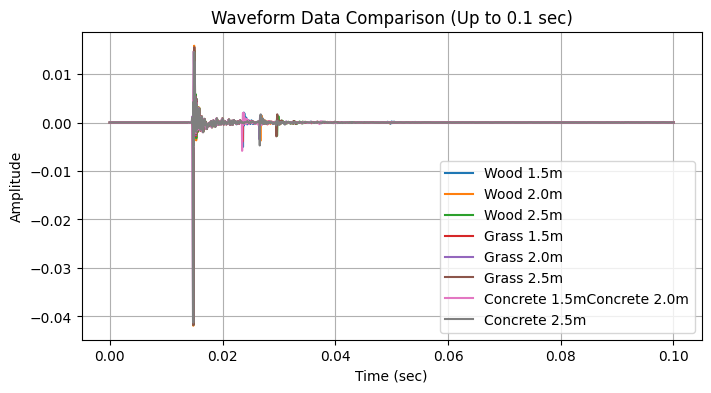

In [2]:
# 複数のCSVファイルを読み込んで、同じ時間幅（0.1秒まで）でそれぞれの波形データをプロットする
dir_ref = "impulse_response_measured"
file_paths = [
    f"{dir_ref}/wood_1_5.csv",
    f"{dir_ref}/wood_2_0.csv",
    f"{dir_ref}/wood_2_5.csv",
    f"{dir_ref}/grass_1_5.csv",
    f"{dir_ref}/grass_2_0.csv",
    f"{dir_ref}/grass_2_5.csv",
    f"{dir_ref}/concrete_1_5.csv",
    f"{dir_ref}/concrete_2_0.csv",
    f"{dir_ref}/concrete_2_5.csv"
]

# 各ファイルを読み込んでデータフレームに格納
dataframes = [pd.read_csv(file_path) for file_path in file_paths]

# 各データフレームの時間を0.1秒までに制限
filtered_dataframes = [df[df.iloc[:, 0] <= 0.1] for df in dataframes]

# プロットの設定
plt.figure(figsize=(8, 4))

labels = [
    "Wood 1.5m",
    "Wood 2.0m",
    "Wood 2.5m",
    "Grass 1.5m",
    "Grass 2.0m",
    "Grass 2.5m",
    "Concrete 1.5m"
    "Concrete 2.0m",
    "Concrete 2.5m",
]

for df, label in zip(filtered_dataframes, labels):
    plt.plot(df.iloc[:, 0], df.iloc[:, 1], label=label)

plt.title("Waveform Data Comparison (Up to 0.1 sec)")
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# プロットの表示
plt.show()


wood
1.5 m, 0.010324 sec, 0.168256
2.0 m, 0.013362 sec, 0.122832
2.5 m, 0.016288 sec, 0.096857


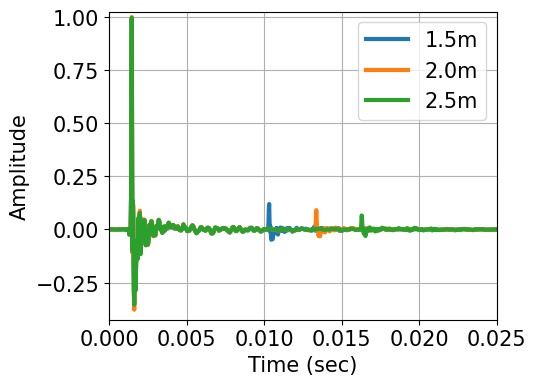

grass
1.5 m, 0.010233 sec, 0.132847
2.0 m, 0.013226 sec, 0.115165
2.5 m, 0.016174 sec, 0.108872


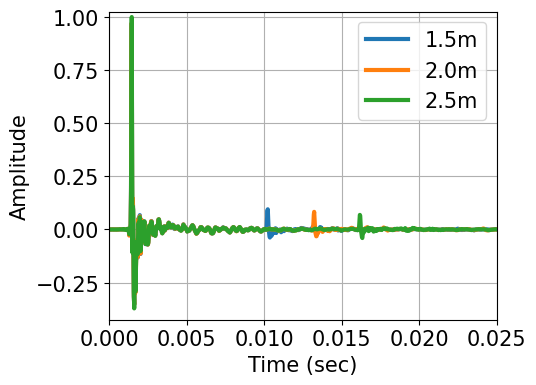

concrete
1.5 m, 0.010165 sec, 0.189170
2.0 m, 0.013249 sec, 0.154455
2.5 m, 0.016197 sec, 0.124718


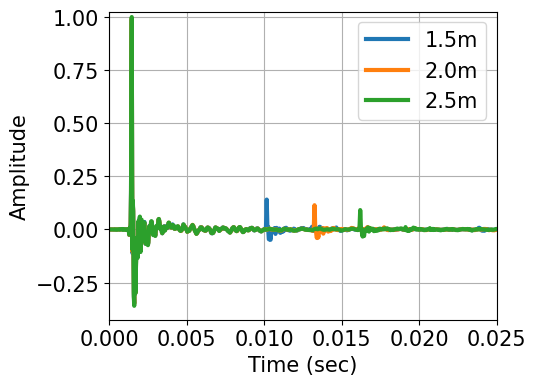

In [3]:
dir_ref = "impulse_response_measured"

for material in ["wood", "grass", "concrete"]:
    print(material)

    plt.figure(figsize=(5, 4))
    plt.rcParams["font.size"] = 15

    dfs = []

    for height in ["1.5", "2.0", "2.5"]:
        df = pd.read_csv(f"{dir_ref}/{material}_{height.replace('.', '_')}.csv")
        # amplitudeカラムを正負反転
        df["amplitude"] = -df["amplitude"]

        # 直接音の到達時間を補正
        max_idx = df["amplitude"].idxmax()
        max_time = df["time"].iloc[max_idx]
        offset = max_time - 0.5 / 343
        df["time"] = df["time"] - offset

        # timeで範囲を絞ってデータを取得
        df = df[(df["time"] >= 0) & (df["time"] <= 0.025)].reset_index(drop=True)
        dfs.append(df)

    max_amplitude = max([df["amplitude"].max() for df in dfs])

    # plot
    for df, height in zip(dfs, ["1.5", "2.0", "2.5"]):
        # 正規化
        df["amplitude"] = df["amplitude"] / max_amplitude
        plt.plot(df["time"], df["amplitude"], label=f"{height}m", linewidth=3)
        # idx = df[df["time"] > 0.005]["amplitude"].idxmax()
        # print(f"{height} m, {df['time'].iloc[idx]:5f} sec, {df['amplitude'].iloc[idx]:5f}")
        idx_max = df[df["time"] > 0.005]["amplitude"].idxmax()
        idx_min = df[df["time"] > 0.005]["amplitude"].idxmin()
        amp = df["amplitude"].iloc[idx_max] - df["amplitude"].iloc[idx_min]
        print(f"{height} m, {df['time'].iloc[idx_max]:5f} sec, {amp:5f}")

    plt.xlim(0, 0.025)
    plt.ylim(-0.425, 1.025)
    plt.xlabel("Time (sec)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    # 保存
    # plt.savefig(f"rir_measured_{material}.pdf", bbox_inches="tight")
    plt.show()

In [4]:
def create_outdoor_room(room_dim, fs, material):
    m = pra.make_materials(floor=material)
    # Create a material for the air (other surfaces)
    air_absorption = 1.0
    air_material = pra.Material(energy_absorption=air_absorption)

    # Set the air material to all other surfaces
    for direction in ["ceiling", "east", "west", "north", "south"]:
        m[direction] = air_material

    floor_material = pra.Material(energy_absorption=material)
    m["floor"] = floor_material

    room = pra.ShoeBox(room_dim, fs=fs, materials=m, max_order=17)
    return room

0.14
1.5 m, 0.010204 sec, 0.152211
2.0 m, 0.013129 sec, 0.111009
2.5 m, 0.016032 sec, 0.105249


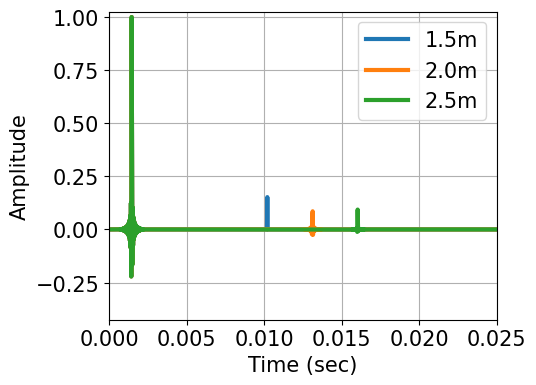

0.3
1.5 m, 0.010204 sec, 0.137324
2.0 m, 0.013129 sec, 0.100151
2.5 m, 0.016032 sec, 0.094955


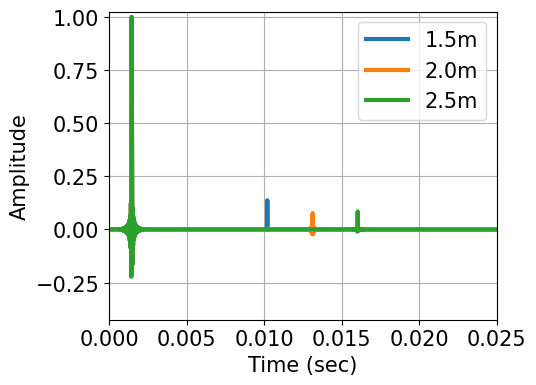

0.0
1.5 m, 0.010204 sec, 0.164133
2.0 m, 0.013129 sec, 0.119704
2.5 m, 0.016032 sec, 0.113493


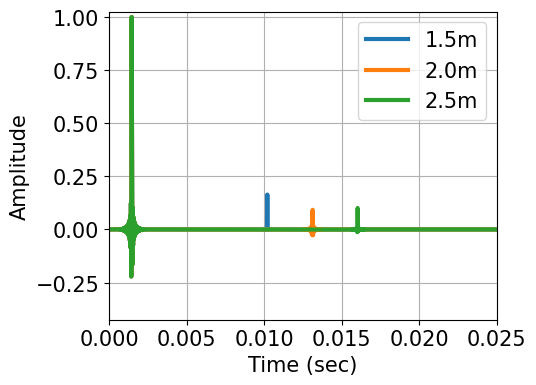

In [5]:
sample_rate = 44100
side_length = 10
signal = np.random.randn(sample_rate * 1)

# for material in ["wooden_lining", "curtains_cotton_0.5", "brick_wall_rough"]:
for material in [0.14, 0.3, 0.0]:
# "rough_concrete" "concrete_floor" "unpainted_concrete"
    print(material)

    plt.figure(figsize=(5, 4))
    plt.rcParams["font.size"] = 15

    dfs = []

    for height in [1.5, 2.0, 2.5]:
        room = create_outdoor_room(np.full(3, side_length), fs=sample_rate, material=material)
        mic_positions = np.array([[5], [5], [height]])
        room.add_microphone_array(pra.MicrophoneArray(mic_positions, room.fs))
        room.add_source([5, 5, height + 0.5], signal=signal)
        room.compute_rir()

        rir = room.rir[0][0]
        max_idx = rir.argmax()
        rir = rir[max_idx - int(0.5 / 343 * sample_rate):]

        max_length = int(0.025 * sample_rate)
        x = np.array(range(max_length)) / sample_rate

        # df作成
        df = pd.DataFrame({
            "time": x,
            "amplitude": rir[:max_length]
        })

        # timeで範囲を絞ってデータを取得
        df = df[(df["time"] >= 0) & (df["time"] <= 0.04)].reset_index(drop=True)
        dfs.append(df)

    max_amplitude = max([df["amplitude"].max() for df in dfs])

    # plot
    for df, height in zip(dfs, ["1.5", "2.0", "2.5"]):
        # 正規化
        df["amplitude"] = df["amplitude"] / max_amplitude
        plt.plot(df["time"], df["amplitude"], label=f"{height}m", linewidth=3)
        idx_max = df[df["time"] > 0.005]["amplitude"].idxmax()
        idx_min = df[df["time"] > 0.005]["amplitude"].idxmin()
        amp = df["amplitude"].iloc[idx_max] - df["amplitude"].iloc[idx_min]
        print(f"{height} m, {df['time'].iloc[idx_max]:5f} sec, {amp:5f}")

    plt.xlim(0, 0.025)
    plt.ylim(-0.425, 1.025)
    plt.xlabel("Time (sec)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()